# Assignment 5 - AML - Hyperparameter Optimization of a Neural Network

### Federica Fiorentini
### Score number: 807124

In [89]:
!apt-get install swig
!pip install smac[all] openml

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-license-10-2 cuda-npp-10-1 cuda-npp-dev-10-1
  cuda-nsight-10-1 cuda-nsight-compute-10-1 cuda-nsight-systems-10-1
  cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1 cuda-nvjpeg-10-1
  cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1 cuda-nvvp-10-1
  libcublas10 libnvidia-common-430 nsight-compute-2019.5.0
  nsight-systems-2019.5.2
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [0]:
#import libraries

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import copy

from collections import Counter

from scipy.stats import uniform

import pprint

import logging
logging.basicConfig(level=logging.INFO)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

import seaborn as sns

def warn(*args, **kwargs):
  pass

import warnings
warnings.warn =  warn

from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,cross_val_score)
from sklearn.neural_network import MLPClassifier

from smac.configspace import ConfigurationSpace
from smac.optimizer.acquisition import LCB, EI
from smac.scenario.scenario import Scenario

from skopt.space import Real, Integer, Space
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize

Per risolvere questo task  di Hyper Parameter Optimization viene utilizzato il dataset *Fertility*, disponibile sul sito web *OpenML* (https://www.openml.org/d/1473). 
Il dataset si riferisce ad un problema di classificazione binaria e contiene 10 feature numeriche compresa la variabile target e si riferisce a circa 100 istanze. 

In [0]:
#import file 'Fertility'
df = pd.read_csv('fertility.csv')

In [92]:
#view the firsts 10 instances 
df.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,Class
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,1
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,2
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,1
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,1
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,2
5,-0.33,0.67,1,0,1,0,0.8,0,0.50,1
6,-0.33,0.67,0,0,0,-1,0.8,-1,0.44,1
7,-0.33,1.00,1,1,1,0,0.6,-1,0.38,1
8,1.00,0.64,0,0,1,0,0.8,-1,0.25,1
9,1.00,0.61,1,0,0,0,1.0,-1,0.25,1


Counter({1: 88, 2: 12})


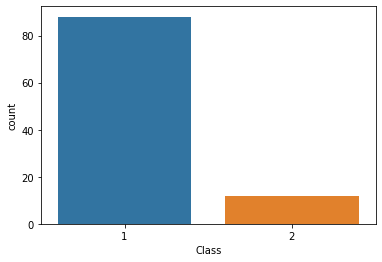

In [93]:
#class frequencies
sns.countplot(df.Class)
print(Counter(df.Class))

Come si nota dal grafico, siamo in presenza del cosiddetto Class Imbalance Problem e, a tal proposito, verrà effettuato un Oversampling randomico per ottenere una variabile target equidistribuita.

In [0]:
#map the class into 0-1 values
df.Class = df.Class.map(lambda x: 0 if x == 1 else 1)

In [0]:
#define Y as the target variable and X the rest ones
X = np.array(df.drop("Class", axis = 1))
y = np.array(df.Class)

In [0]:
#define plot to be used at the end to see results
def results(dic, runs):
  x_ax = np.arange(runs)
  plt.figure(figsize=(15, 8))
  ax = plt.subplot(111)
  for alg in dic:
    ax.plot(x_ax, dic[alg]['bestseen'], '-o', label=alg)
  ax.legend(loc='upper center', 
            bbox_to_anchor=(0.5, -0.08), 
            shadow=True, 
            ncol=2)
  plt.title('Best Seen')
  plt.xlabel('Iterations')
  plt.ylabel('Best Accuracy up to Iteration')
  plt.show()

In [0]:
#random seed
SEED=42

In [0]:
#define two function in order to obtain the Scenario and the Configuration Space
def get_scenario(cs, runs):
  return Scenario({
    "run_obj": "quality",
    "runcount-limit": runs,
    "cs": cs,
    "deterministic": True    
    })
  
def get_cs(*params, random_seed=SEED):
  cs = ConfigurationSpace(seed=random_seed)
  cs.add_hyperparameters(list(params))
  return cs

In [0]:
#define learning rate and momentum interval
lr_low = 0.01
lr_up = 0.1
momentum_low = 0.1
momentum_up = 0.9

paramnames = ['learning_rate_init', 'momentum']

### First task
**HPO for just 2 neural network's hyper-parameters**

In [0]:
#perform the oversample and define the classifier
def task1(**cfg):
  smote = SMOTE(random_state=SEED)
  mlp = MLPClassifier(hidden_layer_sizes=(4,2,),
                      solver='sgd',
                      random_state=SEED,
                      batch_size=32,
                      **cfg
                      )
  model_pipeline = Pipeline([('smote', smote), 
                            ('mlp', mlp)],
                            verbose=True)
  
  return model_pipeline

res1 = {}

### Sequential Model Based Optimization (SMBO) using two different acquisition functions


In [0]:
#create the space with parameters' value
space  = [Real(0.01, 0.1, 'uniform', name='learning_rate_init'),
          Real(0.1, 0.9, name='momentum')]


@use_named_args(space)
def task1score(**kwargs):
  clf = task1(**kwargs)
  scores = cross_val_score(clf, X, y, cv=10)
  return -scores.mean()

In [0]:
#set the initial configuration and the next 20 iterations
initial_runs_1 = 5
further_runs_1 = 20

In [0]:
space_obj = Space(space)
x0 = space_obj.rvs(initial_runs_1, random_state=SEED)
y0 = list(map(task1score, x0)) 

In [104]:
#apply the gaussian process using both the aquisition function, Lower Confidence Bound and Expected Improvement
for acq_fun in ("LCB", "EI"):
  res = gp_minimize(task1score, dimensions=space,
                    n_calls=further_runs_1, n_random_starts=0,
                    acq_func=acq_fun, x0=x0, y0=y0, random_state=SEED,
                    verbose=True)
  best = res.x
  bestseen = -np.minimum.accumulate(res.func_vals)
  res1[f"SMBO - {acq_fun}"] = {
      "best": dict(zip(paramnames, best)),
      "bestseen": bestseen
  }

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 0.1334
Function value obtained: -0.7005
Current minimum: -0.7067
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 3.1684
Function value obtained: -0.5109
Current minimum: -0.7067
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 3.2882
Function value obtained: -0.7067
Current minimum: -0.7067
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 2.3216
Function value obtained: -0.6544
Current minimum: -0.7067
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 2.2810
Function value obtained

### Grid Search

In [0]:
model_pipeline = task1()

In [0]:
#create the grid for the algorithm
lr_range = np.linspace(lr_low, lr_up, 5)
momentum_range = np.linspace(momentum_low, momentum_up, 5)

grid_params = {'mlp__learning_rate_init': lr_range,
               'mlp__momentum': momentum_range}

In [0]:
#perform the Grid Search algorithm 
cv = GridSearchCV(estimator=model_pipeline,
                  param_grid=grid_params,
                  cv=10)

In [0]:
cv.fit(X, y);

In [0]:
prog = cv.cv_results_['mean_test_score']
best = list(cv.best_params_.values())
bestseen = np.maximum.accumulate(prog)


res1['Grid Search'] = {
    'best': dict(zip(paramnames, best)),
    'bestseen': bestseen
}

### Random Search

In [0]:
lr_dist = uniform(lr_low, lr_up - lr_low)
lr_dist.random_state = np.random.RandomState(SEED)

mom_dist = uniform(momentum_low, momentum_up - momentum_low)
mom_dist.random_state = np.random.RandomState(SEED)

random_params = {
    'mlp__learning_rate_init': lr_dist,
    'mlp__momentum': mom_dist
    }

In [0]:
#perform the Grid Search algorithm 
randomcv = RandomizedSearchCV(estimator=model_pipeline,
                              param_distributions=random_params,
                              n_iter=25,
                              cv=10,
                              random_state=SEED)

In [0]:
randomcv.fit(X, y);

In [0]:
prog = randomcv.cv_results_['mean_test_score']
best = list(randomcv.best_params_.values())
bestseen = np.maximum.accumulate(prog)
           
res1['Random Search'] = {
    'best': dict(zip(paramnames, best)),
    'bestseen': bestseen
}

### Compare the results

In [114]:
#compare results of Grid Search, Random Search, SMBO-EI and SMBO-LCB
pprint.pprint(res1)

{'Grid Search': {'best': {'learning_rate_init': 0.05500000000000001,
                          'momentum': 0.9},
                 'bestseen': array([0.51, 0.59, 0.6 , 0.67, 0.67, 0.67, 0.67, 0.69, 0.69, 0.69, 0.69,
       0.69, 0.7 , 0.71, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72,
       0.72, 0.72, 0.72])},
 'Random Search': {'best': {'learning_rate_init': 0.07587945476302646,
                            'momentum': 0.5789267873576293},
                   'bestseen': array([0.68, 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 ,
       0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 ,
       0.7 , 0.7 , 0.7 ])},
 'SMBO - EI': {'best': {'learning_rate_init': 0.05208438306302848,
                        'momentum': 0.9},
               'bestseen': array([0.69050505, 0.70666667, 0.70666667, 0.70666667, 0.70666667,
       0.70666667, 0.70666667, 0.70666667, 0.70666667, 0.70666667,
       0.70666667, 0.70666667, 0.70666667, 0.70666667, 0.70666667,
       0.7

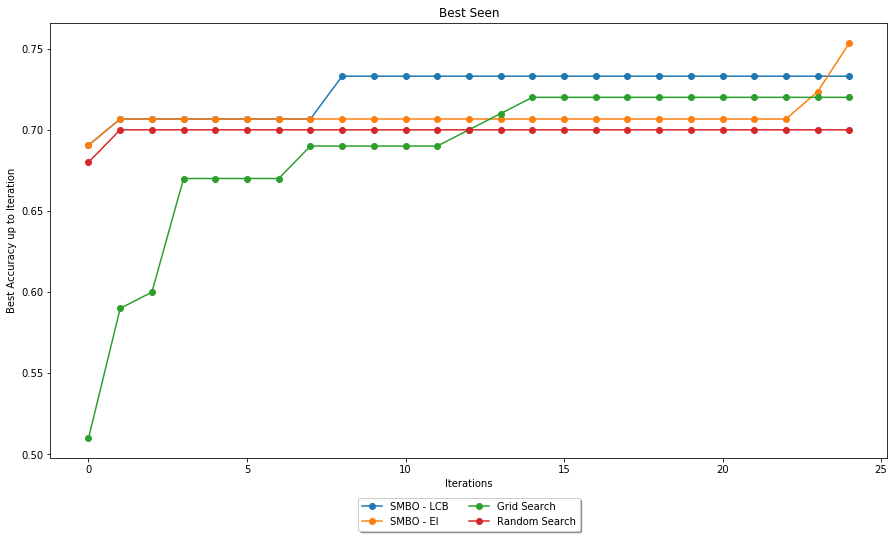

In [115]:
#plot accuracy reached by Grid Search, Random Search, SMBO-EI and SMBO-LCB up to iteration
results(res1, runs=initial_runs_1 + further_runs_1)

### Second Task
**HPO for just 4 neural network's hyper-parameters**

In [0]:
#define number of neurons space
neurons_low = 1
neurons_up = 5

initial_runs_2 = 10
further_runs_2 = 100

paramnames_2 = copy.deepcopy(paramnames)
paramnames_2.extend(['layer1_neurons', 'layer2_neurons'])

In [0]:
#perform the oversample and define the classifier
def task2(**cfg):
  smote = SMOTE(random_state=SEED)
  mlp = MLPClassifier(hidden_layer_sizes=(cfg["layer1_neurons"], 
                                          cfg["layer2_neurons"],),
                      solver='sgd',
                      random_state=SEED,
                      batch_size=64,
                      learning_rate_init=cfg["learning_rate_init"],
                      momentum = cfg["momentum"]
                      )
  return make_pipeline(smote, mlp)

In [0]:
space2 = copy.deepcopy(space)
space2.extend(
    [Integer(1, 5, name=f"layer{i}_neurons") for i in (1,2)]
    )

In [0]:
@use_named_args(space2)
def task2score(**kwargs):
  clf = task2(**kwargs)
  scores = cross_val_score(clf, X, y, cv=10)
  return -scores.mean()

In [0]:
space_obj2 = Space(space2)
x0_2 = space_obj2.rvs(initial_runs_2, random_state=SEED)
y0_2 = list(map(task2score, x0_2))

In [121]:
#apply the Random Forest using both the aquisition function, Lower Confidence Bound and Expected Improvement
res2 = {}
for acq in ("EI", "LCB"):
  res = forest_minimize(task2score, dimensions=space2,
                        n_calls=further_runs_2, n_random_starts=0,
                        acq_func=acq, x0=x0_2, y0=y0_2, random_state=SEED,
                        verbose=True)
  best = res.x
  bestseen = -np.minimum.accumulate(res.func_vals)
  res2[f"SMBO - {acq}"] = {
      "best": dict(zip(paramnames_2, best)),
      "bestseen": bestseen
  }

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 0.3136
Function value obtained: -0.6495
Current minimum: -0.8028
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 2.3072
Function value obtained: -0.7737
Current minimum: -0.8028
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 0.4918
Function value obtained: -0.7259
Current minimum: -0.8028
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 0.6257
Function value obtained: -0.4341
Current minimum: -0.8028
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 1.9622
Function value obtained

In [122]:
res2

{'SMBO - EI': {'best': {'layer1_neurons': 5,
   'layer2_neurons': 1,
   'learning_rate_init': 0.08994636043620045,
   'momentum': 0.8997438302582764},
  'bestseen': array([0.5859596 , 0.60949495, 0.80282828, 0.80282828, 0.80282828,
         0.80282828, 0.80282828, 0.80282828, 0.80282828, 0.80282828,
         0.80282828, 0.80282828, 0.80282828, 0.80282828, 0.80282828,
         0.80282828, 0.80282828, 0.80282828, 0.80282828, 0.80282828,
         0.80282828, 0.80282828, 0.80282828, 0.80282828, 0.80282828,
         0.80282828, 0.80282828, 0.80282828, 0.80282828, 0.80282828,
         0.80282828, 0.80282828, 0.80282828, 0.80282828, 0.80282828,
         0.80282828, 0.80282828, 0.80282828, 0.80282828, 0.80282828,
         0.80282828, 0.80282828, 0.80282828, 0.80282828, 0.80282828,
         0.80282828, 0.80282828, 0.80282828, 0.80282828, 0.88141414,
         0.88141414, 0.88141414, 0.88141414, 0.88141414, 0.88141414,
         0.88141414, 0.88141414, 0.88141414, 0.88141414, 0.88141414,
         

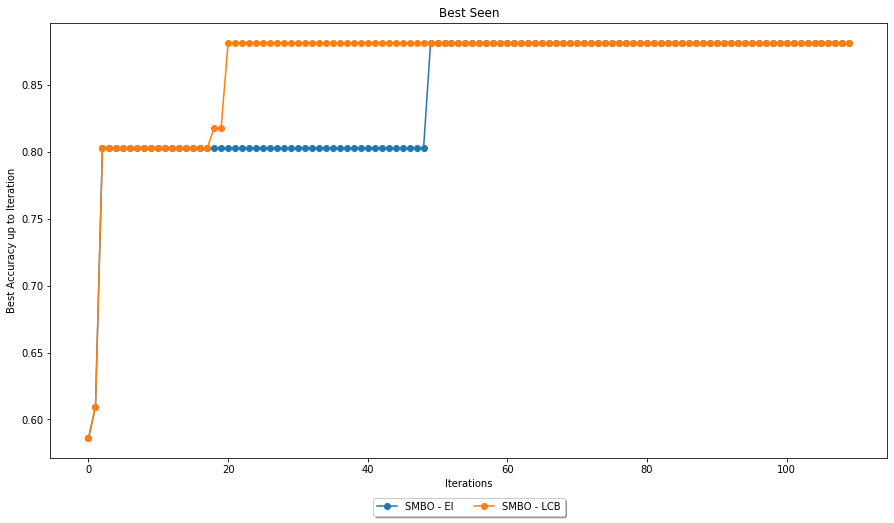

In [123]:
#plot results
results(res2, runs=initial_runs_2 + further_runs_2)